In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from functions import compute_r, rho_model, log_rho_model, compute_r_fast, compute_distance_from_axis

import pandas as pd
import numpy as np
from itertools import zip_longest
import re
import os

from scipy.optimize import minimize
from scipy.special import gamma
from scipy.special import gammaln
from scipy.optimize import differential_evolution

In [75]:
coordinates_df = pd.read_csv('../data/coordinates.csv')
coordinates_df.head(3)

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684
1,1,1.2,-37.609,5.885,-6.684
2,1,1.3,-37.609,-7.315,-6.684


## corsika

In [76]:
run = 1630
nrun = 163010
filename = f'pDAT{nrun}'
save_path = f'csv_output/{filename}_output/' 
params_file = '_params.csv'

j_event = 2
event_filename = save_path + f'event_{j_event}.csv'

In [77]:
params_df = pd.read_csv(save_path + params_file)
params_df.head(3)

,event_id,Ne,s,energy_prim,theta_prim,phi_prim
0,0,391831.97,1.368396,10000000.0,30.0,157.843280
1,1,1135387.00,1.259589,10000000.0,30.0,154.390050
2,2,307665.75,1.370902,10000000.0,30.0,3.547332


In [78]:
geant_df = pd.read_csv(f'../corsika_geant/csv_output/p{run}_2022.csv', converters={
    "AmplKSM": eval, "hSM": eval, "nTrackSMX": eval, "nTrackSMY": eval, "nTrackSM": eval,
    "hSM0": eval, "nTrackSMX0": eval, "nTrackSMY0": eval, "nTrackSM0": eval,
    "EdepCntSCT": eval, "EdepDetNE": eval, "TimDetNE": eval, "EdepStNE": eval, "TimStNE": eval
})
geant_df.head(5)

,N_event,NRUN,NEVENT,PART0,E0,Teta,Fi,XAxisShift,YAxisShift,H1INT,...,hSM0,nTrackSMX0,nTrackSMY0,nTrackSM0,EdepCntSCT,EdepDetNE,TimDetNE,EdepStNE,TimStNE,marker
0,0.0,163000.0,1.0,14.0,10000000.0,30.0,250.81110,-3.604914,17.520945,2037503.8,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[275.1681213378906, 393.967041015625, 240.89...","[[[[77899.65625, 77853.4765625, 77853.296875, ...","[[1223.07861328125, 568.7264404296875, 392.765...","[[[78024.15625, 77859.4453125, 77852.359375, 7...",-1.0
1,1.0,163000.0,2.0,14.0,10000000.0,30.0,137.26013,34.682972,29.802770,1618705.4,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[57.04955291748047, 82.13531494140625, 29.59...","[[[[61772.8203125, 61730.67578125, 61709.38281...","[[218.79034423828125, 161.58436584472656, 22.0...","[[[61789.25390625, 61710.42578125, 61709.38281...",-1.0
2,2.0,163000.0,3.0,14.0,10000000.0,30.0,213.97726,-31.952726,-70.088340,1750923.4,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[45.41700744628906, 40.191585540771484, 36.9...","[[[[66978.2421875, 66938.6640625, 66928.789062...","[[152.75584411621094, 217.80645751953125, 236....","[[[67056.3671875, 66925.90625, 66925.78125, 66...",-1.0
3,3.0,163000.0,4.0,14.0,10000000.0,30.0,250.50570,4.174946,-64.528380,1980956.9,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[58.76924514770508, 49.20310592651367, 68.90...","[[[[75859.21875, 75804.8671875, 75802.53125, 7...","[[201.5207977294922, 130.53219604492188, 190.5...","[[[75864.5546875, 75804.8671875, 75801.7109375...",-1.0
4,4.0,163000.0,5.0,14.0,10000000.0,30.0,244.36765,8.919296,-21.378675,2109477.2,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[56.4903678894043, 73.44979858398438, 67.729...","[[[[80799.40625, 80672.609375, 80672.4609375, ...","[[307.9816589355469, 243.0980224609375, 294.64...","[[[80799.40625, 80685.9375, 80672.4609375, 806...",-1.0


In [79]:
mask = geant_df['NRUN'].astype(int) == nrun

geant_nrun_df = geant_df[mask].head(5)

E_1_event = geant_nrun_df['EdepStNE'].iloc[j_event]

theta_g = geant_nrun_df['Teta'].iloc[j_event]
phi_g = geant_nrun_df['Fi'].iloc[j_event]

X0_g = geant_nrun_df['XAxisShift'].iloc[j_event]
Y0_g = geant_nrun_df['YAxisShift'].iloc[j_event]
Z0_g = -18

Ne_g = geant_nrun_df['NeNKGlong'].iloc[j_event]
s_g = geant_nrun_df['sNKGlong'].iloc[j_event]

X = coordinates_df['X']
Y = coordinates_df['Y']
Z = coordinates_df['Z']

if not Ne_g == Ne and not s_g == s:
    print('error Ne, s')

error Ne, s


In [80]:
X0, Y0 = 0, 0
Ne, s = params_df['Ne'].iloc[j_event], params_df['s'].iloc[j_event]
theta, phi = theta_g, phi_g 

In [81]:
event_df = pd.read_csv(event_filename)

# e_df = event_df[event_df['particle_name'].isin(['e-', 'e+'])].copy()
e_df = event_df.copy()
e_df.head(3)

,event_id,particle_name,pid,x,y,t,energy
0,2,gamma,1,-146.355732,7.827697,102646.445,0.029572
1,2,e-,2,-46.516416,-3.428895,102491.800,0.009269
2,2,e+,3,-45.750566,-4.175639,102490.500,0.022181


### nkg corsika

In [82]:
print(f'{len(e_df)}/{len(event_df)}')

2871504/2871504


In [83]:
all_counts = [e_df[(e_df['x'].between(st.X - 0.4, st.X + 0.4)) & 
                  (e_df['y'].between(st.Y - 0.4, st.Y + 0.4))].shape[0]
             for st in coordinates_df.itertuples()]

# Затем группируем по 4
registration = [list(group) for group in zip_longest(*[iter(all_counts)]*4, fillvalue=None)]
registration = [[x for x in group if x is not None] for group in registration]

In [84]:
r_corsika = compute_distance_from_axis(X0, Y0, theta, phi, coordinates_df['X'], coordinates_df['Y'])

In [85]:
filtered_registration = []
filtered_r = []
filtered_coordinates = []  


cluster_indices = np.arange(len(coordinates_df)) // 4  

for cluster_id in np.unique(cluster_indices):
    mask = (cluster_indices == cluster_id)
    
    cluster_reg = registration[cluster_id]
    cluster_r = r_corsika[mask]
    cluster_coords = coordinates_df[mask]

    if sum(val > 0 for val in cluster_reg) >= 2:
        for reg_val, r_val, (_, coord_row) in zip(cluster_reg, cluster_r, cluster_coords.iterrows()):
            if reg_val > 0:
                filtered_registration.append(reg_val)
                filtered_r.append(r_val)
                filtered_coordinates.append(coord_row)

filtered_coordinates_df = pd.DataFrame(filtered_coordinates)
assert len(filtered_r) == len(filtered_coordinates_df) 

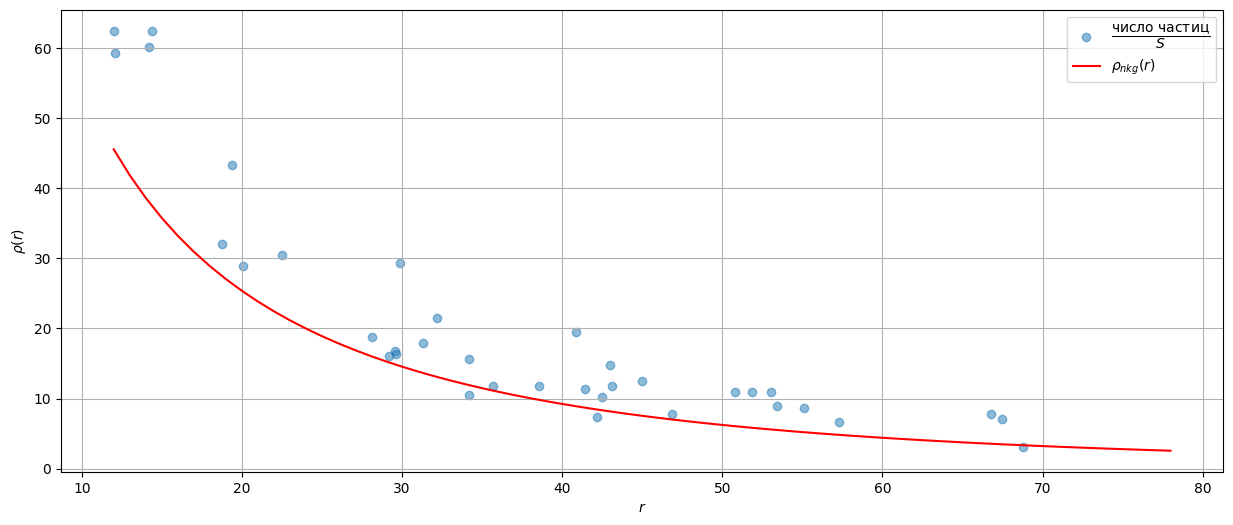

In [86]:
rho = np.array(filtered_registration) / (4 * 0.8 * 0.8)
r_enterval = np.arange(min(filtered_r), max(filtered_r) + 10, 1)
rho_calculate = rho_model(r_enterval, Ne, s)


plt.figure(figsize=(15, 6))
plt.scatter(filtered_r, rho , alpha=0.5, label=r'$\dfrac{\text{число частиц}}{S}$')
plt.plot(r_enterval, rho_calculate, c='r', label=r'$\rho_{nkg}(r)$')

plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')
plt.legend()
plt.grid(True)

plt.show()

In [49]:
def loss_function(params, coordinates_df, rho, theta, phi, Z0):
    eps = 1e-10 
    X0, Y0, Ne, s = params
    X_det, Y_det = coordinates_df[['X', 'Y']].values.T
    Z_det = Z0
    r = compute_distance_from_axis(X0, Y0, theta, phi, X_det, Y_det)
    rho_calc = rho_model(r, Ne, s)
    return np.mean((np.log(rho_calc + eps) - np.log(rho + eps)) ** 2)

bounds = [
    (-50, 50),
    (-80, 80),
    (1, 1e8),  
    (0.2, 2)  
]

In [50]:
result = differential_evolution(
    loss_function,
    bounds,
    args=(filtered_coordinates_df, rho, theta, phi, -17)
    )

result = minimize(
    loss_function, 
    result.x, 
    args=(filtered_coordinates_df, rho, theta, phi, -17),
    method='Nelder-Mead', 
    bounds=bounds
)

X0_opt, Y0_opt, Ne_opt, s_opt = result.x

d:\github\repositories\sdf\corsika\functions.py:29: RuntimeWarning: divide by zero encountered in power
  term2 = (r / r_m) ** (s - 2)


     X0    Y0        Ne     s
0  0.00  0.00  4.14e+05  1.36
1  0.48 -1.74  5.52e+05  1.30


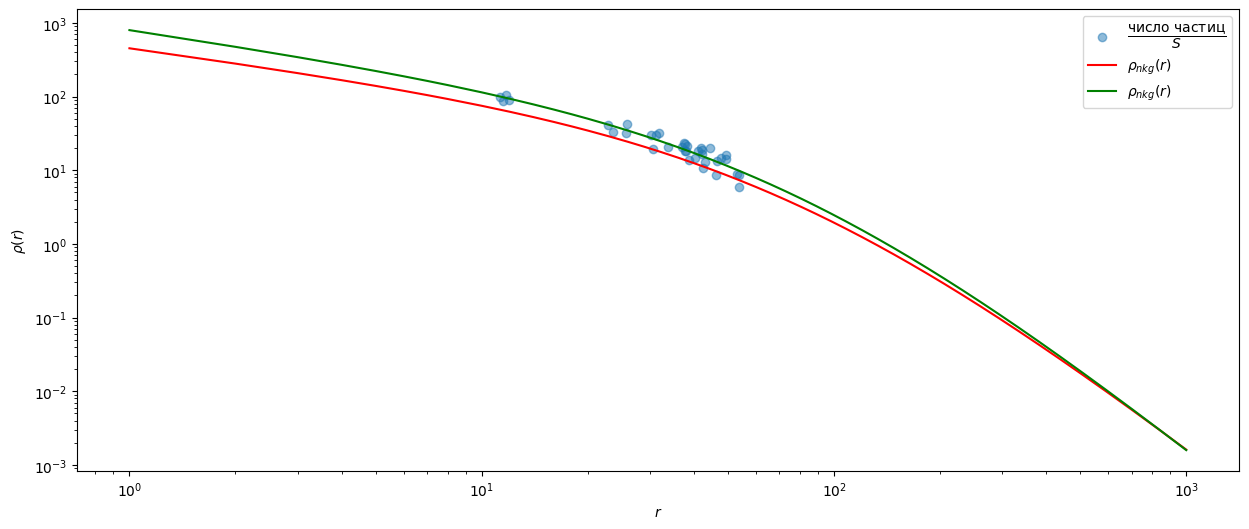

In [53]:
rho = np.array(filtered_registration) / (4 * 0.8 * 0.8)
r_enterval = np.arange(0, 1e3, 1)
rho_calculate = rho_model(r_enterval, Ne, s)

R = compute_distance_from_axis(X0, Y0, theta, phi, filtered_coordinates_df['X'], filtered_coordinates_df['Y'])
rho_calculate_fit = rho_model(r_enterval, Ne_opt, s_opt)

df = pd.DataFrame({'X0': [X0, X0_opt], 'Y0': [Y0, Y0_opt]})
df = pd.DataFrame({
    'X0': np.round([X0, X0_opt], 2),
    'Y0': np.round([Y0, Y0_opt], 2),
    'Ne': [np.format_float_scientific(val, precision=2) for val in [Ne, Ne_opt]],
    's': np.round([s, s_opt], 2),
})
df.head(3)
print(df)

plt.figure(figsize=(15, 6))
plt.scatter(filtered_r, rho , alpha=0.5, label=r'$\dfrac{\text{число частиц}}{S}$')
plt.plot(r_enterval, rho_calculate, c='r', label=r'$\rho_{nkg}(r)$')
plt.plot(r_enterval, rho_calculate_fit, c='green', label=r'$\rho_{nkg}(r)$')

plt.yscale('log')
plt.xscale('log')
           
plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')
plt.legend()
plt.show()

## geant

In [54]:
geant_df = pd.read_csv(f'../corsika_geant/csv_output/p{run}_2022.csv', converters={
    "AmplKSM": eval, "hSM": eval, "nTrackSMX": eval, "nTrackSMY": eval, "nTrackSM": eval,
    "hSM0": eval, "nTrackSMX0": eval, "nTrackSMY0": eval, "nTrackSM0": eval,
    "EdepCntSCT": eval, "EdepDetNE": eval, "TimDetNE": eval, "EdepStNE": eval, "TimStNE": eval
})
geant_df.head(1)

,N_event,NRUN,NEVENT,PART0,E0,Teta,Fi,XAxisShift,YAxisShift,H1INT,...,hSM0,nTrackSMX0,nTrackSMY0,nTrackSM0,EdepCntSCT,EdepDetNE,TimDetNE,EdepStNE,TimStNE,marker
0,0.0,163000.0,1.0,14.0,10000000.0,30.0,250.8111,-3.604914,17.520945,2037503.8,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[275.1681213378906, 393.967041015625, 240.89...","[[[[77899.65625, 77853.4765625, 77853.296875, ...","[[1223.07861328125, 568.7264404296875, 392.765...","[[[78024.15625, 77859.4453125, 77852.359375, 7...",-1.0


In [55]:
mask = geant_df['NRUN'].astype(int) == nrun

geant_nrun_df = geant_df[mask].head(5)

E_1_event = geant_nrun_df['EdepStNE'].iloc[j_event]

theta_g = geant_nrun_df['Teta'].iloc[j_event]
phi_g = geant_nrun_df['Fi'].iloc[j_event]

X0_g = geant_nrun_df['XAxisShift'].iloc[j_event]
Y0_g = geant_nrun_df['YAxisShift'].iloc[j_event]
Z0_g = -18

Ne_g = geant_nrun_df['NeNKGlong'].iloc[j_event]
s_g = geant_nrun_df['sNKGlong'].iloc[j_event]

X = coordinates_df['X']
Y = coordinates_df['Y']
Z = coordinates_df['Z']

if not Ne_g == Ne and not s_g == s:
    print('error Ne, s')

### nkg geant

In [56]:
r_geant = compute_r(X0_g, Y0_g, Z0_g, theta_g, phi_g, X, Y, Z)

In [57]:
e_list = []
for i_cluster, cluster in enumerate(E_1_event):
    for j_station, value in enumerate(cluster):
        e_list.append(
            {'cluster': i_cluster+1, 'station': j_station+1, 'E': value})

E_stations = pd.DataFrame(e_list)
E_stations.head(2)

,cluster,station,E
0,1,1,159.748199
1,1,2,65.056641


In [58]:
N_e = E_stations['E'] / 8.2
mask = N_e > 0.75
N_e = N_e[mask]
S = 0.8 * 0.8 * 4
rho_geant = N_e/S

In [59]:
result = differential_evolution(
    loss_function,
    bounds,
    args=(coordinates_df[mask], rho_geant, theta_g, phi_g, Z0_g)
    )

result = minimize(
    loss_function, 
    result.x, 
    args=(coordinates_df[mask], rho_geant, theta_g, phi_g, Z0_g),
    method='Nelder-Mead', 
    bounds=bounds
)

X0_g_opt, Y0_g_opt, Ne_g_opt, s_g_opt = result.x

In [60]:
X0_g_opt, Y0_g_opt, Ne_g_opt, s_g_opt 

(11.59495834839268, -57.687641767433234, 332054.9383963836, 1.2023816603753383)

In [61]:
X0_g, Y0_g, Ne_g, s_g

(15.718891, -68.5655, 414350.84, 1.3645059)

      X0     Y0        Ne     s
0  15.72 -68.57  4.14e+05  1.36
1  11.59 -57.69  3.32e+05  1.20


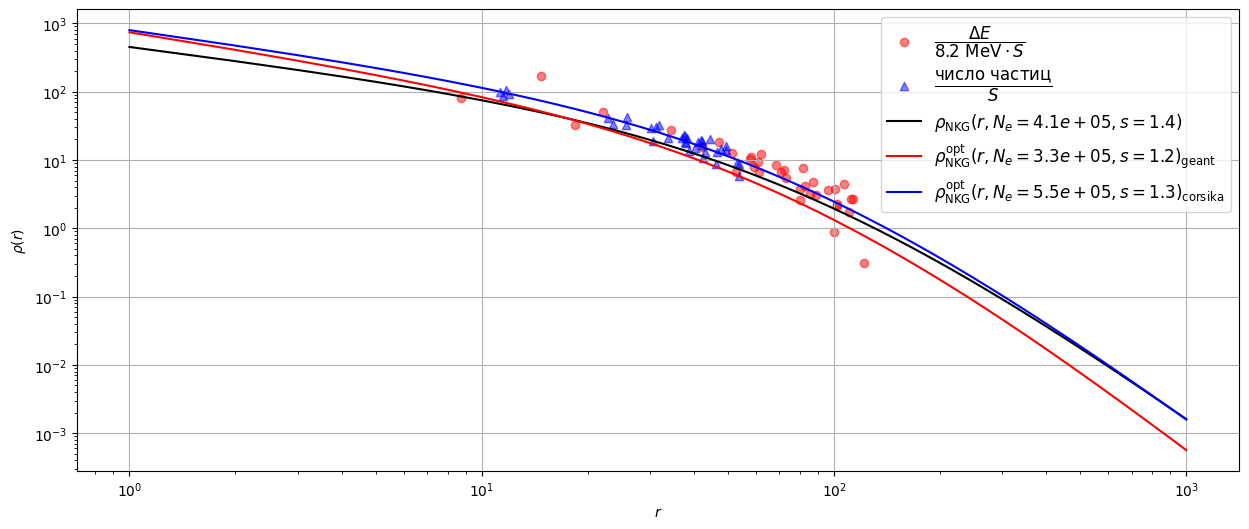

In [62]:
r_enterval_g = np.arange(1, 1e3, 1)
rho_calculate_g = rho_model(r_enterval_g, Ne_g, s_g)


# R = compute_distance_from_axis(X0, Y0, theta, phi, filtered_coordinates_df['X'], filtered_coordinates_df['Y'])
rho_calculate_fit_g = rho_model(r_enterval_g, Ne_g_opt, s_g_opt)

df = pd.DataFrame({'X0': [X0_g, X0_g_opt], 'Y0': [Y0_g, Y0_g_opt]})
df = pd.DataFrame({
    'X0': np.round([X0_g, X0_g_opt], 2),
    'Y0': np.round([Y0_g, Y0_g_opt], 2),
    'Ne': [np.format_float_scientific(val, precision=2) for val in [Ne_g, Ne_g_opt]],
    's': np.round([s_g, s_g_opt], 2),
})
df.head(3)
print(df)

plt.figure(figsize=(15, 6))
plt.scatter(r_geant[mask], rho_geant , alpha=0.5, color='r', label=r'$\dfrac{\Delta E}{8.2~\text{МеV} \cdot S}$')
plt.scatter(filtered_r, rho , alpha=0.5, color='b',marker = '^', label=r'$\dfrac{\text{число частиц}}{S}$')
plt.plot(r_enterval_g, rho_calculate_g, c='black',
        label=fr'$\rho_{{\text{{NKG}}}}(r, N_e={Ne_g:.1e}, s={s_g:.1f})$')

plt.plot(r_enterval_g, rho_calculate_fit_g, c='red', 
         label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_g_opt:.1e}, s={s_g_opt:.1f})_\text{{geant}}$')

plt.plot(r_enterval, rho_calculate_fit, c='blue', 
        label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_opt:.1e}, s={s_opt:.1f})_\text{{corsika}}$')

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')
plt.legend(fontsize=12)
# plt.savefig(f'plots/{163010}/event_{j_event}.png',
#             dpi=500, bbox_inches="tight")
plt.show()